In [1]:
from helpers import *
from implementations import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt

# Loading Data and Preprocessing

In [2]:
#data_folder = './data/'
data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [3]:
csv_data = load_csv_data(data_folder, max_rows=None, dictionnary=True)

# Replace zeros and default values before preprocessing
convert_to_times_per_week(csv_data['x_train'], csv_data['bad_format_no_better'])
convert_to_times_per_week(csv_data['x_test'], csv_data['bad_format_no_better'])
replace_by_zero(csv_data['x_train'], csv_data['x_test'], csv_data['zero_values'])
replace_default_with_nan(csv_data['x_train'], csv_data['x_test'], csv_data['default_values'])

print_shapes(csv_data)


x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)


In [4]:
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from 222 to 512.


c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


215 features with low correlation dropped.
Clipped 1857428 values in x_train (1.91% of all entries)
Clipped 619268 values in x_test (1.91%)


In [5]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 297)
x_test: <class 'numpy.ndarray'> with shape (109379, 297)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (297,)
useless: <class 'numpy.ndarray'> with shape (297,)
health_related: <class 'numpy.ndarray'> with shape (297,)
better_elsewhere: <class 'numpy.ndarray'> with shape (297,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (297,)
binary: <class 'numpy.ndarray'> with shape (297,)
one_hot: <class 'numpy.ndarray'> with shape (297,)
zero_values: <class 'numpy.ndarray'> with shape (297,)
default_values: <class 'numpy.ndarray'> with shape (709,)
x_val: <class 'numpy.ndarray'> with shape (32813, 297)
y_val: <class 'numpy.ndarray'> with shape (32813,)


Our dataset is unbalanced

Ratio of majority class to minority class: 10.32


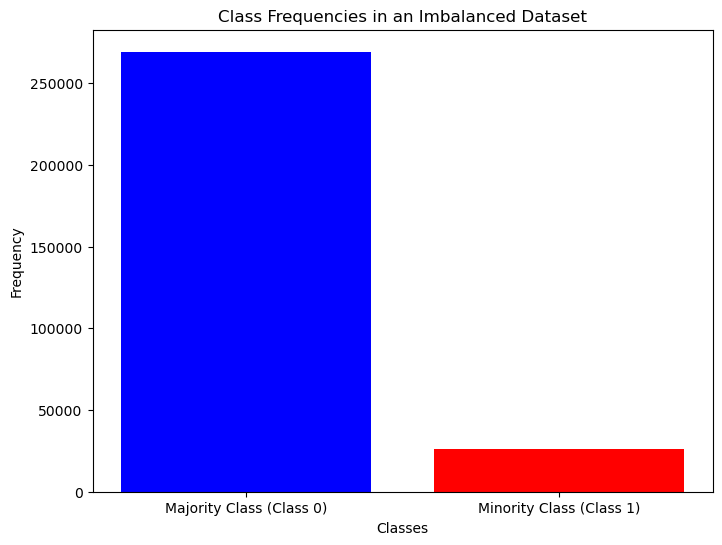

In [6]:

# Count the frequencies of each class
class_counts = [len(data_copy['y_train'][data_copy['y_train'] == 0]), len(data_copy['y_train'][data_copy['y_train'] == 1])]

print(f"Ratio of majority class to minority class: {class_counts[0] / class_counts[1]:.2f}")

# Plot the class frequencies using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Majority Class (Class 0)', 'Minority Class (Class 1)'], class_counts, color=['blue', 'red'])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequencies in an Imbalanced Dataset')
plt.show()

# Model Selection and Hyperparameters tuning

## Learning Rate Selection in Logistic Regression

Crossvalidation to find best learning rate

In [7]:
# Using the generic cross-validation function
def learning_function(y, tx, gamma):
    initial_w = np.zeros(tx.shape[1])
    return logistic_regression(y, tx, initial_w, max_iters=150, gamma=gamma)

gammas = [0.1, 0.2, 0.4, 0.6, 0.8]

best_gamma, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, gammas)

Param=0.1 | Mean F1=0.3874
Param=0.2 | Mean F1=0.4004
Param=0.4 | Mean F1=0.4106
Param=0.6 | Mean F1=0.4140
Param=0.8 | Mean F1=0.4128

✅ Best param: 0.6 (F1=0.4140)


Even if the best gamma found is more than 0.5, we observe oscillations in the loss function for this value. We thus choose gamma = 0.5 as a trade-off between convergence speed and stability.

In [11]:
best_gamma = 0.6

✅ Best threshold: 0.30 | F1_val = 0.424 | Acc_val = 0.863


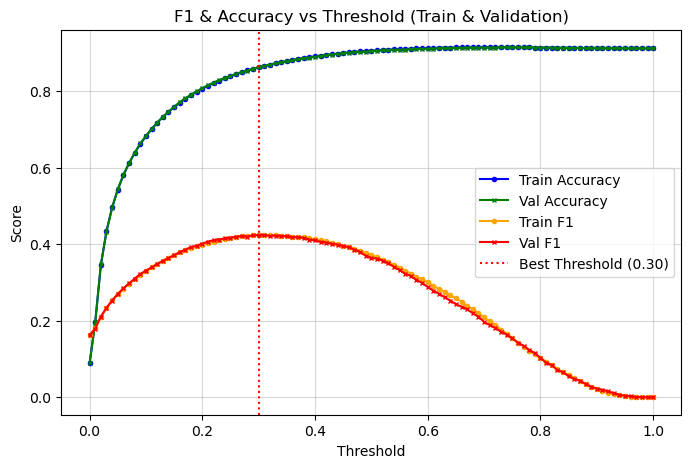

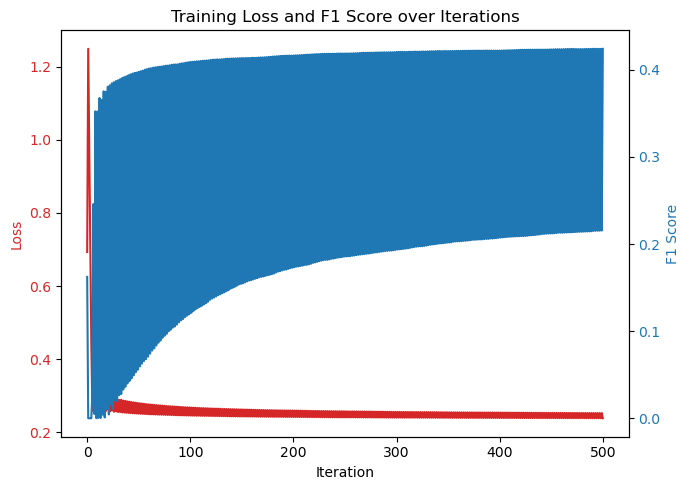

In [12]:
# Train final model with best gamma and get training history
weights, losses = logistic_regression(data_copy['y_train'], data_copy['x_train'], np.zeros(data_copy['x_train'].shape[1]), max_iters=500, gamma=best_gamma, return_history=True)
# Plot training and validation performance
plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

## Lambda tuning in ridge logistic regression

In [13]:
# Using the generic cross-validation function
def learning_function(y, tx, lambda_):
    initial_w = np.zeros(tx.shape[1])
    return reg_logistic_regression(y, tx, lambda_, initial_w, max_iters=150, gamma=best_gamma)

lambdas = [1e-6, 1e-4, 1e-2, 1e-1]

best_lambda, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, lambdas)

Param=1e-06 | Mean F1=0.4140
Param=0.0001 | Mean F1=0.4141
Param=0.01 | Mean F1=0.3980
Param=0.1 | Mean F1=0.3182

✅ Best param: 0.0001 (F1=0.4141)


✅ Best threshold: 0.31 | F1_val = 0.422 | Acc_val = 0.861


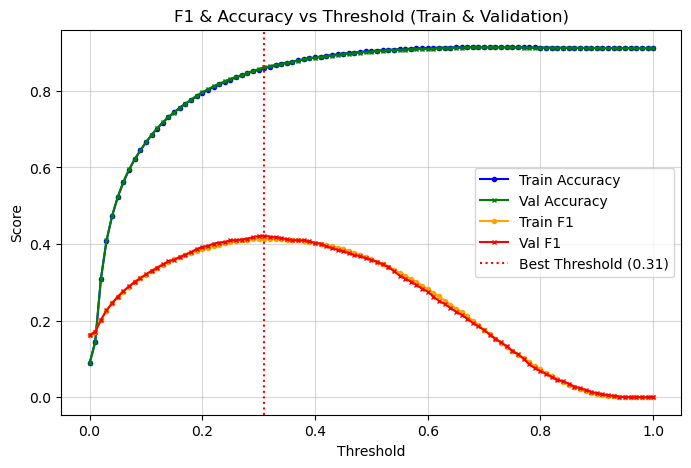

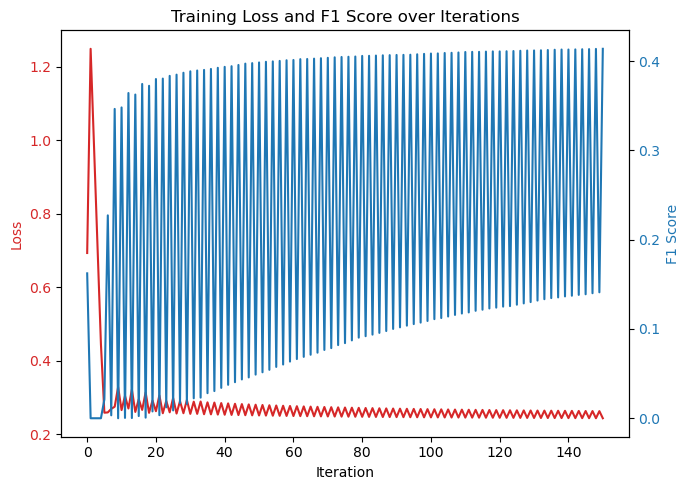

In [14]:
# Train final model with best gamma and get training history
weights, losses = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], best_lambda, np.zeros(data_copy['x_train'].shape[1]), max_iters=150, gamma=best_gamma, return_history=True)
# Plot training and validation performance
plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

## Polynomial Feature Expansion

In [15]:
degrees = [1,2,3]
best_degree, results = cross_validate_degrees(data_copy['x_train'], data_copy['y_train'], degrees, k=5, max_iters=150, gamma=best_gamma)

Degree=1 | Mean F1=0.4140
Degree=2 | Mean F1=0.3816
Degree=3 | Mean F1=0.2311

✅ Best degree: 1 (F1=0.4140)


✅ Best threshold: 0.31 | F1_val = 0.422 | Acc_val = 0.859


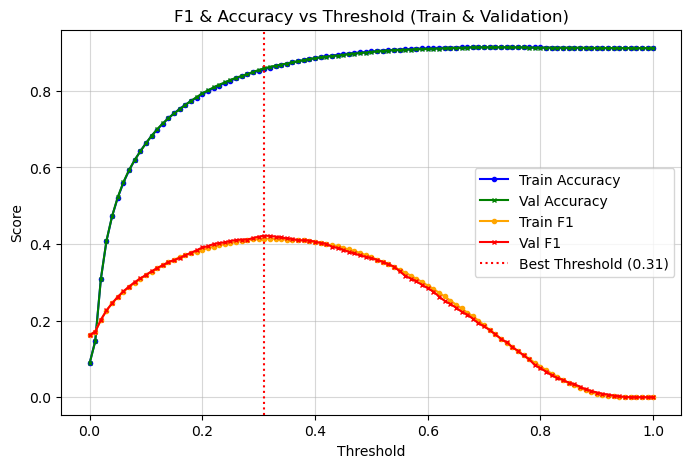

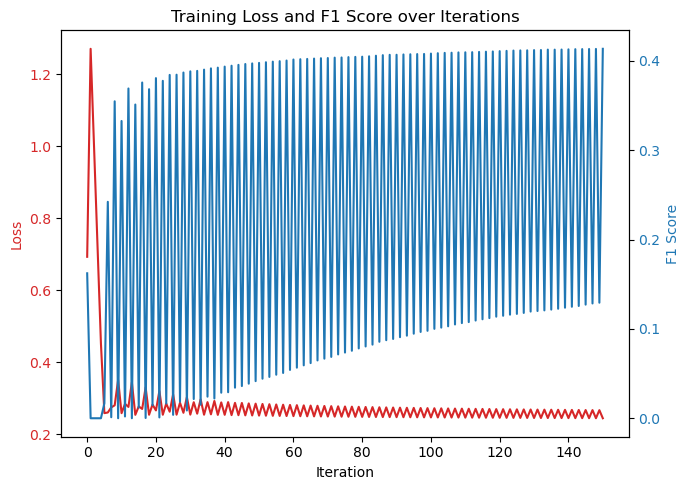

In [16]:
x_train_poly = build_poly(data_copy['x_train'], best_degree)
x_val_poly = build_poly(data_copy['x_val'], best_degree)
x_test_poly = build_poly(data_copy['x_test'], best_degree)

weights, losses = logistic_regression(data_copy['y_train'], x_train_poly, np.zeros(x_train_poly.shape[1]), max_iters=150, gamma=best_gamma, return_history=True)

plot_training_validation_performance(x_train_poly, data_copy['y_train'], x_val_poly, data_copy['y_val'], weights, losses)

## Weighted logistic regression

In [17]:
# Using the generic cross-validation function
def learning_function(y, tx, relative_weight):
    initial_w = np.zeros(tx.shape[1])
    sample_weights = 1 + (relative_weight - 1) * y
    return weighted_reg_logistic_regression(y, tx, 0, sample_weights, initial_w, max_iters=150, gamma=best_gamma)

relative_weights = [1, 4, 6, 10, 14]
best_relative_weight, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, relative_weights)

Param=1 | Mean F1=0.4140
Param=4 | Mean F1=0.4094
Param=6 | Mean F1=0.4083
Param=10 | Mean F1=0.3510
Param=14 | Mean F1=0.4087

✅ Best param: 1 (F1=0.4140)


✅ Best threshold: 0.31 | F1_val = 0.421 | Acc_val = 0.861


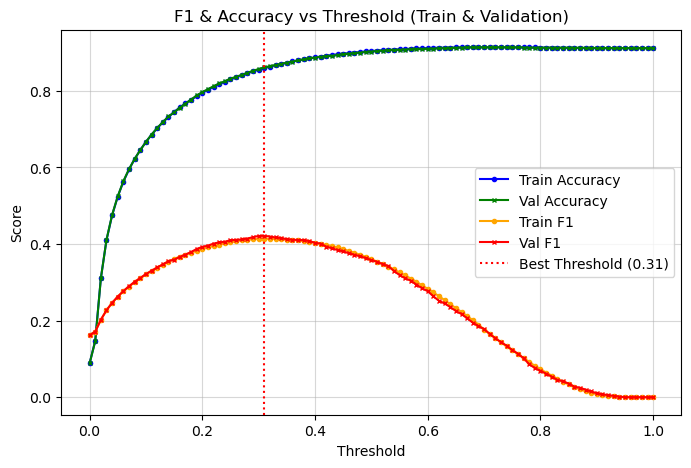

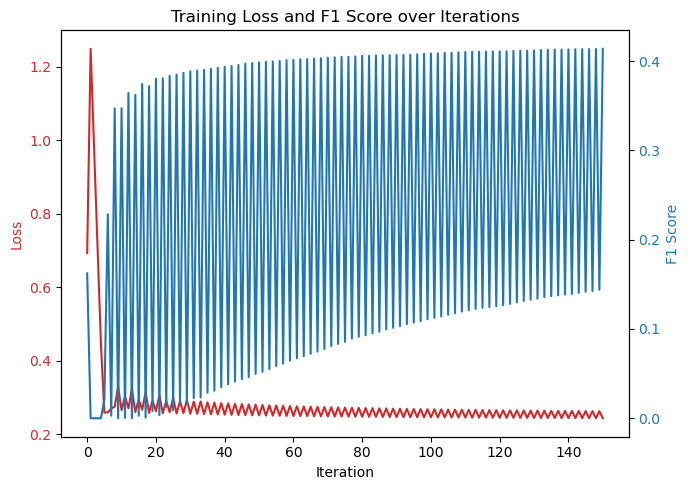

In [18]:
sample_weights = 1 + (best_relative_weight - 1) * data_copy['y_train']
initial_w = np.zeros(data_copy['x_train'].shape[1])
weights, losses = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], 0, sample_weights, initial_w, 150, best_gamma, return_history=True)

plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

## Oversample

In [19]:
def learning_function(y, tx, oversampling_ratio):
    x_over, y_over = oversample_data(tx, y, ratio=oversampling_ratio)
    initial_w = np.zeros(x_over.shape[1])
    return logistic_regression(y_over, x_over, initial_w, max_iters=150, gamma=best_gamma)

ratios = [0.2, 0.4, 0.6, 0.8]
best_ratio, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, ratios)

Param=0.2 | Mean F1=0.4037
Param=0.4 | Mean F1=0.4078
Param=0.6 | Mean F1=0.3998
Param=0.8 | Mean F1=0.3677

✅ Best param: 0.4 (F1=0.4078)


✅ Best threshold: 0.01 | F1_val = 0.415 | Acc_val = 0.860


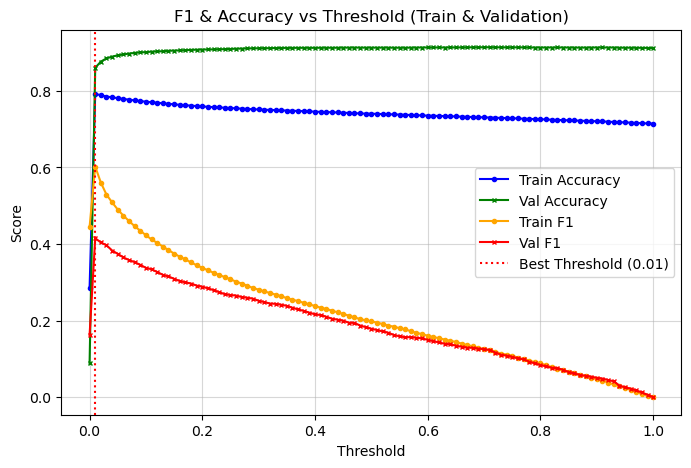

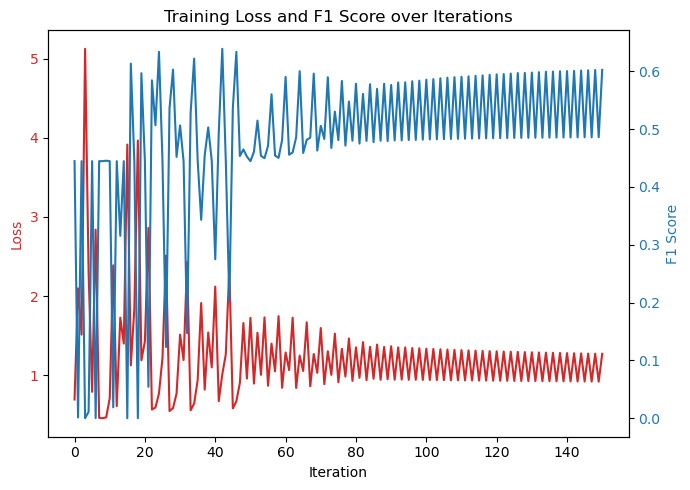

In [20]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights, losses =logistic_regression(y_over, x_over,initial_w, 150, best_gamma, return_history=True)

plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights, losses)

## Submission

Based on the best learning rate, best lambda, best weights for the minority class, and best polynomial degree, we generate the submission file.

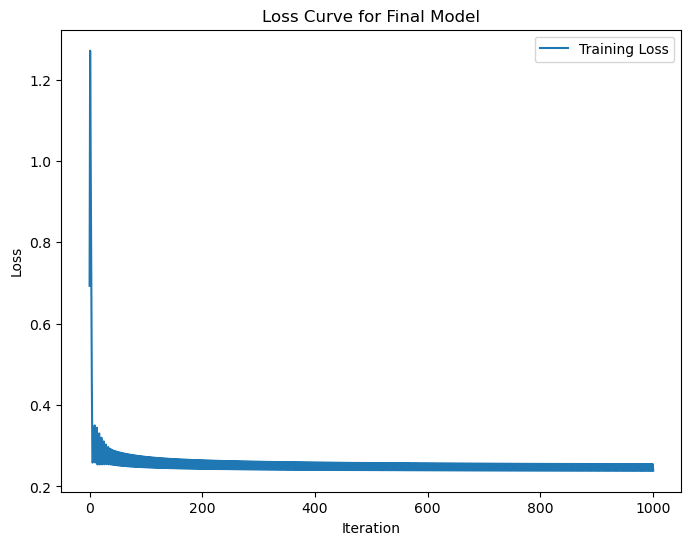

In [21]:
# Train final model with best hyperparameters
# For the final model, we use the maximum number of samples
# x_train_full contains all training samples (train + val)
x_train_full = np.concatenate([data_copy['x_train'], data_copy['x_val']])
y_train_full = np.concatenate([data_copy['y_train'], data_copy['y_val']])

# Polynomial Feature Expansion
x_train_poly = build_poly(x_train_full, best_degree)
x_test_poly = build_poly(data_copy['x_test'], best_degree)

# Best weights for the minority class
sample_weights = 1 + (best_relative_weight - 1) * y_train_full

# Train final model with best hyperparameters
weights, losses = weighted_reg_logistic_regression(y_train_full, x_train_poly, best_lambda, sample_weights, np.zeros(x_train_poly.shape[1]), max_iters=1000, gamma=best_gamma, return_history=True)

# Plot the loss curve for the final model to check convergence
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Final Model')
plt.legend()
plt.show()

# Determine the best threshold on the full training set
best_t, _ = best_threshold(y_train_full, x_train_poly, weights[-1])

# Predict on test set and create submission file
test_pred = predict_labels_logistic(x_test_poly, weights[-1], threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')